# 📈 Tesla Stock Price Prediction using LSTM

This notebook uses an LSTM (Long Short-Term Memory) neural network to forecast Tesla’s stock closing prices. It includes:

- Data preprocessing
- Sequence modeling using TensorFlow/Keras
- Predictions and evaluation (RMSE)
- 30-day future forecasting
- Interactive Plotly graphs


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import math


In [2]:
# Load CSV
df = pd.read_csv("TSLA.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Drop unneeded columns
df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

# Scale close price
scaler = MinMaxScaler()
close_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Train/test split
split = int(0.80 * len(close_data))
close_train, close_test = close_data[:split], close_data[split:]
date_train, date_test = df['Date'][:split], df['Date'][split:]

look_back = 31


/var/folders/p1/6s3z304j6rl964knc01d38xm0000gn/T/ipykernel_56671/3781206036.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
# Create datasets
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=close_train,
    targets=close_train[look_back:],
    sequence_length=look_back,
    batch_size=20,
)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=close_test,
    targets=close_test[look_back:],
    sequence_length=look_back,
    batch_size=1,
)


In [4]:
# Define LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, activation='relu', input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train with early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(train_dataset, epochs=150, verbose=1, callbacks=[early_stop])


Epoch 1/150


/opt/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0104
Epoch 2/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 3/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 4/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2737e-04
Epoch 5/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6485e-04
Epoch 6/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9085e-04
Epoch 7/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9692e-04
Epoch 8/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5060e-04
Epoch 9/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2214e-04
Epoch 10/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0770e-04
Epoch 11/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9718e-04
Epoch 12/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8856e-04
Epoch 13/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8376e-04
Epoch 14/150
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8210e-04
Epoch 15/150
96/96 ━━━━━━━━━━━━━━━━━━━━

In [5]:
# Predict test set
predictions = model.predict(test_dataset, verbose=0)
predictions = scaler.inverse_transform(predictions).flatten()

# Inverse scale actuals
close_test_inv = scaler.inverse_transform(close_test).flatten()
close_train_inv = scaler.inverse_transform(close_train).flatten()

# RMSE
rmse = math.sqrt(mean_squared_error(close_test_inv[look_back:], predictions))
print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 29.16


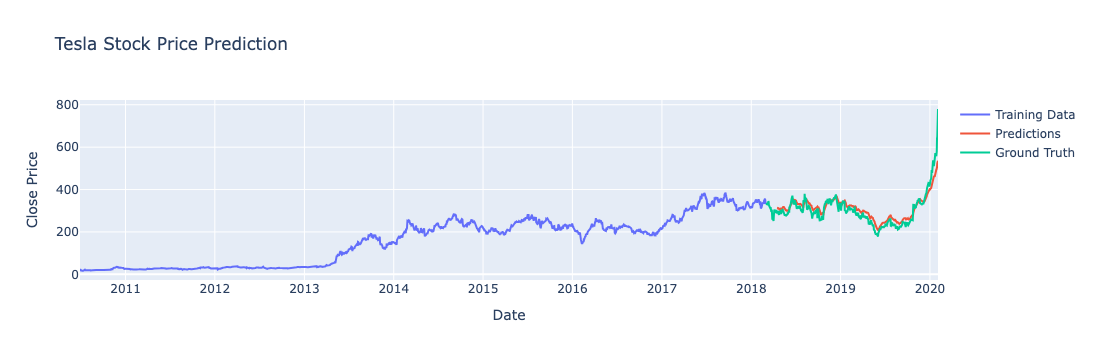

In [6]:
# Plot predictions
trace1 = go.Scatter(x=date_train, y=close_train_inv, mode='lines', name='Training Data')
trace2 = go.Scatter(x=date_test[look_back:], y=predictions, mode='lines', name='Predictions')
trace3 = go.Scatter(x=date_test, y=close_test_inv, mode='lines', name='Ground Truth')

layout = go.Layout(title="Tesla Stock Price Prediction",
                   xaxis={'title': "Date"},
                   yaxis={'title': "Close Price"})

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()


In [7]:
# Forecast future function
def forecast_future(num_prediction, model, close_data, look_back):
    input_seq = close_data[-look_back:]
    predictions = []
    
    for _ in range(num_prediction):
        input_seq = input_seq.reshape((1, look_back, 1))
        next_pred = model.predict(input_seq, verbose=0)[0][0]
        predictions.append(next_pred)
        input_seq = np.append(input_seq[0][1:], next_pred).reshape((look_back, 1))
    
    return predictions

# Predict next 30 days
num_prediction = 30
future_preds = forecast_future(num_prediction, model, close_data, look_back)
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
future_dates = pd.date_range(start=date_test.iloc[-1], periods=num_prediction+1).tolist()[1:]


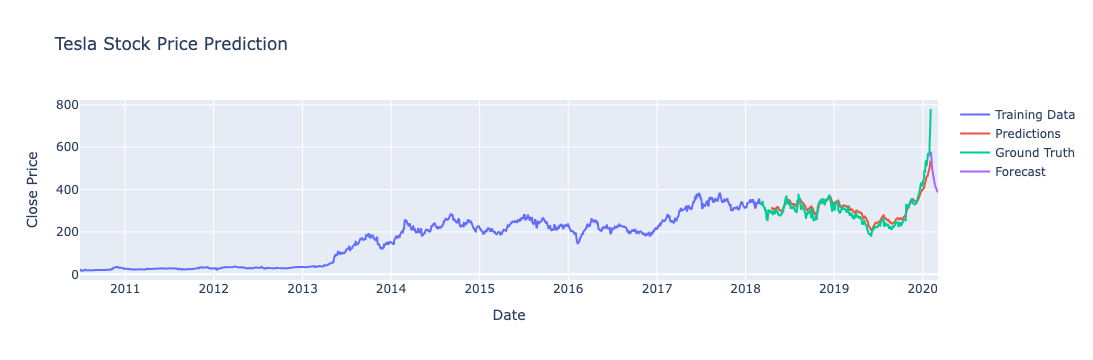

In [8]:
# Add forecast line to existing plot
trace4 = go.Scatter(x=future_dates, y=future_preds, mode='lines', name='Forecast')
fig.add_trace(trace4)
fig.show()


## ✅ Next Steps

- Add more features (volume, indicators, news sentiment)
- Try other RNN architectures (GRU, BiLSTM)
- Tune hyperparameters and sequence lengths
- Deploy with Streamlit for interactive web app

👉 [View code on GitHub](https://github.com/zlundra/tesla-stock-prediction)
